# Harry Potter Universe
From a young age, harry potter has been an integral part of my literary universe. That is why I chose to analyse the various facets of the book that helped me build the foundations of magical realisim in my imagination.

Let's start with importing the necessary libraries for our analysis.

In [2]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx

import matplotlib.pyplot as plt

In [4]:
!py -m spacy download en_core_web_sm

                                              0.0/12.8 MB ? eta -:--:--
                                              0.1/12.8 MB 2.2 MB/s eta 0:00:06
                                              0.3/12.8 MB 2.5 MB/s eta 0:00:05
     -                                        0.5/12.8 MB 3.4 MB/s eta 0:00:04
     --                                       0.8/12.8 MB 4.4 MB/s eta 0:00:03
     ---                                      1.2/12.8 MB 4.8 MB/s eta 0:00:03
     ----                                     1.5/12.8 MB 5.3 MB/s eta 0:00:03
     ------                                   1.9/12.8 MB 5.8 MB/s eta 0:00:02
     -------                                  2.5/12.8 MB 6.6 MB/s eta 0:00:02
     ---------                                2.9/12.8 MB 6.6 MB/s eta 0:00:02
     ----------                               3.5/12.8 MB 7.2 MB/s eta 0:00:02
     ------------                             4.1/12.8 MB 7.9 MB/s eta 0:00:02
     -------------                            4.4/12.8 MB 7


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# Spacy English language model
NER = spacy.load('en_core_web_sm')

We'll extract relevant information from the first book - Philosopher's Stone.

In [10]:
# Grab the first book
book_text = open("D:\Purvi\Book-character-visualizations\harry_potter\data\Book 1 - The Philosopher's Stone.txt", encoding="utf8").read()

In [12]:
# Send text to the model
book_doc = NER(book_text)


In [13]:
# Visulize part of a book with entities that catched
displacy.render(book_doc[:200], style='ent', jupyter=True)

In [14]:
# Read csv file that we scraped
character_df = pd.read_csv('D:\Purvi\Book-character-visualizations\harry_potter\data\character_names.csv')

# Clean unnecessary columns
character_df.drop(columns=['Unnamed: 0'],inplace=True)

In [15]:
# Strip data for better matching
character_df.names = character_df.names.str.strip(' ')

In [16]:
character_df.head()


,names,last_name,first_name
0,Euan Abercrombie,Abercrombie,Euan
1,Steward Ackerley,Ackerley,Steward
2,Falcon Aesalon,Aesalon,Falcon
3,Agnes,Agnes,NaN
4,Cornelius Agrippa,Agrippa,Cornelius


In [17]:
sent_entity_df = []

# Loop all sentences and save each entity per sentences
for sent in book_doc.sents:
    
    # Get entities found in sentence
    entity_list = [ent.text for ent in sent.ents]
    
    # Save sentences and entities as dictionary
    sent_entity_df.append({'sentence':sent,'entity':entity_list})

sent_entity_df = pd.DataFrame(sent_entity_df)

In [18]:
sent_entity_df.head()

,sentence,entity
0,"(/, \n\n\n\n\n, THE, BOY, WHO, LIVED, \n\n, Mr...","[LIVED, Dursley, number four, Privet Drive]"
1,"(They, were, the, last, people, you, ’d, \n, e...",[]
2,"(Mr., Dursley, was, the, director, of, a, firm...","[Dursley, Grunnings]"
3,"(He, was, a, big, ,, beefy, \n, man, with, har...",[]
4,"(Mrs., Dursley, was, thin, and, \n, blonde, an...",[Dursley]


In [19]:
# Function to filter entities with character names
def filter_entity(entitiy_list, character_df):
    """
    
    This function filters entities for characters in our character_df dataframe.
    
    Parameters:
    entitiy_list -- list of entities found by model
    character_df -- data frame which has all character names
    
    Output:
    a list of entities that are characters (matching by names or first names).
    
    """
    
    return [entity for entity in entitiy_list
            if entity in list(character_df.names.unique())
            or entity in list(character_df.first_name.unique())
    ]

In [20]:
# Apply filter_entity function to our data frame.
sent_entity_df['entity'] = sent_entity_df['entity'].apply(lambda x: filter_entity(x, character_df))

# Filter out sentences with no entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df.entity.map(len)>0]

In [21]:
sent_entity_df_filtered.head()

,sentence,entity
5,"(The, Dursley, s, had, a, small, son, \n, call...",[Dudley]
8,"(Mrs., Potter, was, Mrs., Dursley, ’s, sister,...",[Harry Potter]
11,"(This, boy, was, another, good, reason, for, k...",[Dudley]
13,"(Mr., Dursley, hummed, as, he, picked, out, \n...",[Dudley]
15,"(At, half, past, eight, ,, Mr., Dursley, picke...","[Dudley, Dudley]"


In [22]:
# Filter only for first name (eg. Harry Potter and Harry is same person so they need to appear as same name)
sent_entity_df_filtered['entity'] = sent_entity_df_filtered['entity'].apply(lambda x: [item.split(' ')[0] for item in x])

C:\Users\Purvi\AppData\Local\Temp\ipykernel_29932\1327914986.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['entity'] = sent_entity_df_filtered['entity'].apply(lambda x: [item.split(' ')[0] for item in x])


In [23]:
sent_entity_df_filtered.head()

,sentence,entity
5,"(The, Dursley, s, had, a, small, son, \n, call...",[Dudley]
8,"(Mrs., Potter, was, Mrs., Dursley, ’s, sister,...",[Harry]
11,"(This, boy, was, another, good, reason, for, k...",[Dudley]
13,"(Mr., Dursley, hummed, as, he, picked, out, \n...",[Dudley]
15,"(At, half, past, eight, ,, Mr., Dursley, picke...","[Dudley, Dudley]"


In [24]:
# Window size for reading through a book
window_size = 5

relationships = []

# Loop for reading through book by window size.
for i in range(sent_entity_df_filtered.index[-1]):
    
    # Being sure end index is not exceeds last index that book has
    end_i = min(i+5,sent_entity_df_filtered.index[-1])
    
    # Concatanate entities which appers in same window size
    char_list = sum((sent_entity_df_filtered.loc[i : end_i].entity), [])
    
    # Remove duplicated character which is in same window size (eg. we are not looking for relationship which Harry has with himself)
    char_unique = list(set(char_list))
    
    # Save entities appears next to each other
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx+1]
            relationships.append({'source':a, 'target':b})

In [25]:
# Create data frame for relationships
relationship_df = pd.DataFrame(relationships)

In [26]:
relationship_df.head()

,source,target
0,Harry,Dudley
1,Harry,Dudley
2,Harry,Dudley
3,Harry,Dudley
4,Harry,Dudley


In [27]:
# Clean reversed relationships (eg. Harry -> Dudley and Dudley -> Harry means the same thing)
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis=1), columns = relationship_df.columns)
relationship_df.head()

,source,target
0,Dudley,Harry
1,Dudley,Harry
2,Dudley,Harry
3,Dudley,Harry
4,Dudley,Harry


In [28]:
# Give one point for each appearence
relationship_df['value'] = 1

# Sum all relationships
relationship_df = relationship_df.groupby(['source','target'],sort = False, as_index= False).sum()

In [29]:
relationship_df.head(10)

,source,target,value
0,Dudley,Harry,405
1,Harry,Harvey,1
2,Harold,Harry,5
3,Harold,Harvey,5
4,Harry,Petunia,37
5,Albus,Harry,32
6,James,Lily,7
7,Hagrid,Harry,658
8,Harry,James,11
9,Dudley,Petunia,55


In [30]:
# Create graph from pandas dataframe
G = nx.from_pandas_edgelist(relationship_df,
                            source = 'source',
                            target = 'target',
                            edge_attr ='value',
                            create_using = nx.Graph())

In [45]:
relationship_df['value'].mean()

22.85425101214575

Now finally, lets look at how characters interact with each other throughout the novel. This graph gives a comprehensive view of the various underlying relationships present in the book.

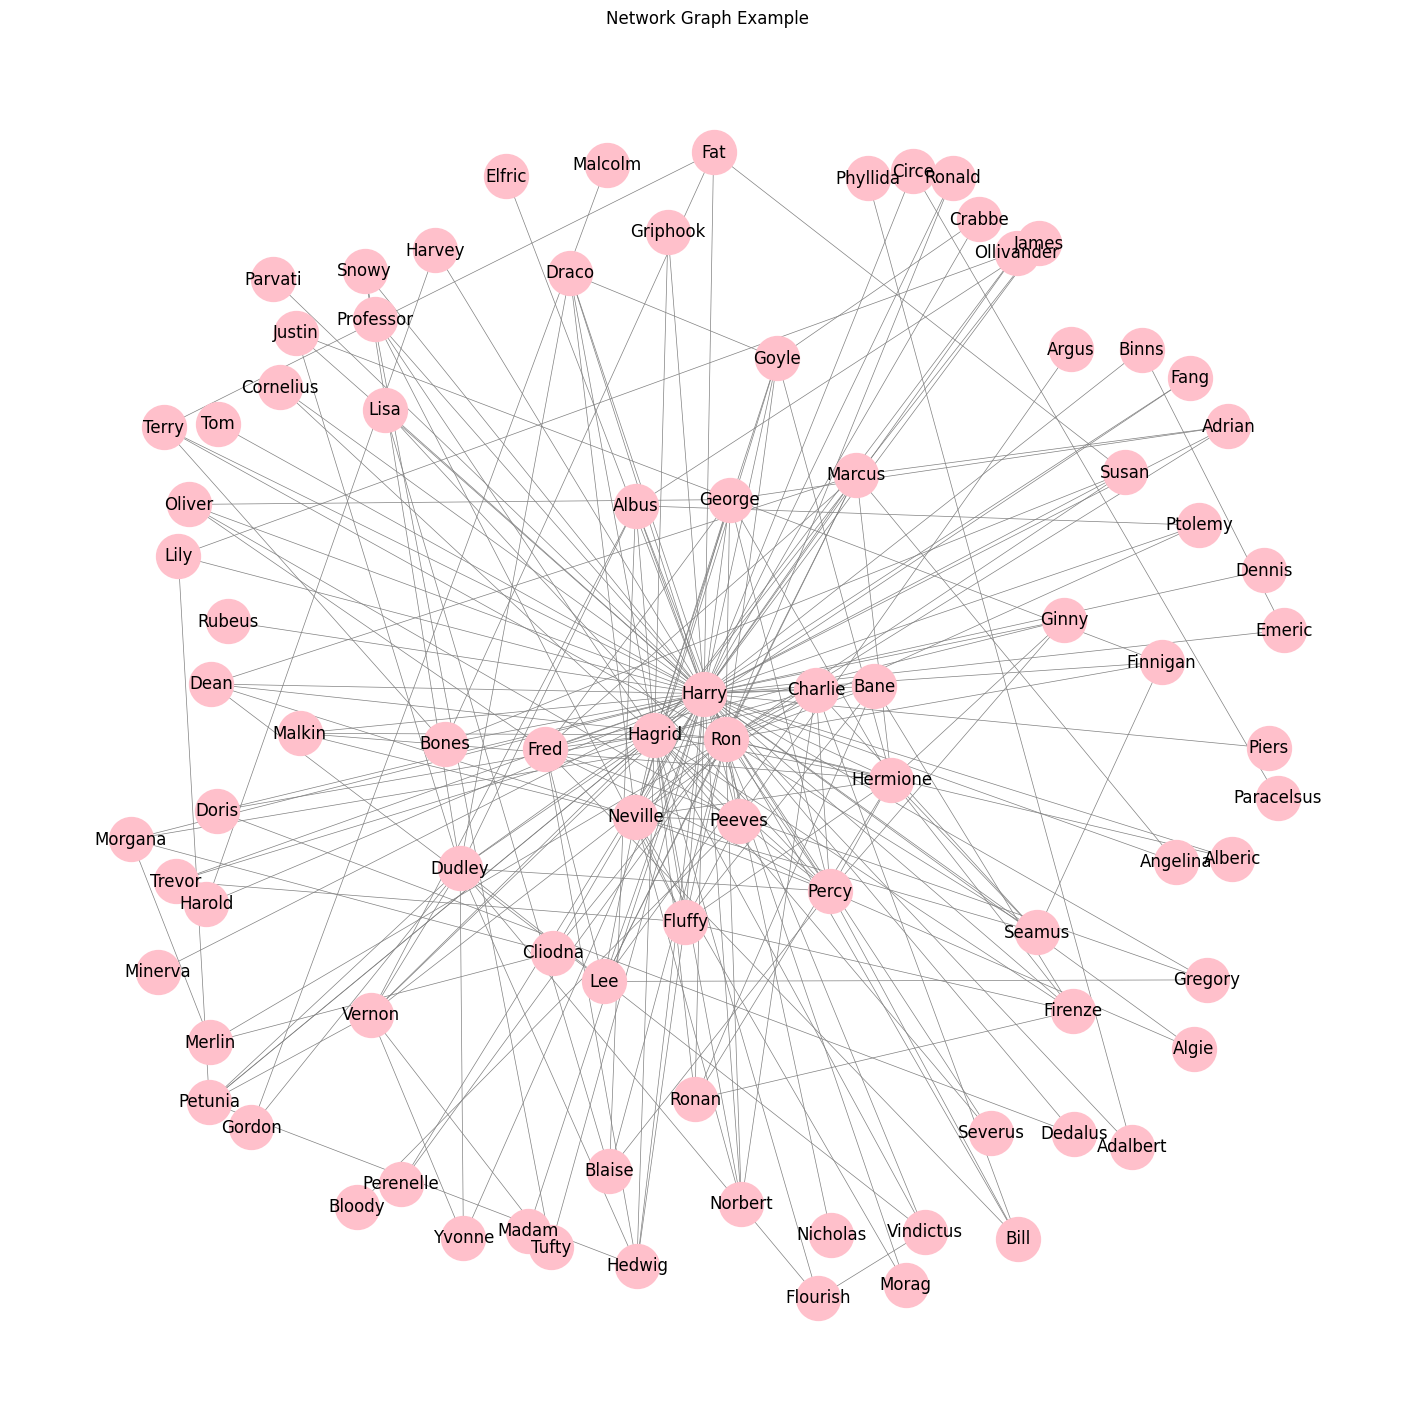

In [59]:
plt.figure(figsize=(18, 18))

# Adjust the layout and spacing
pos = nx.spring_layout(G, k=1.2)

# Draw nodes with different sizes based on their importance
node_sizes = [1000 if node == 'important_node' else 300 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='pink')
# Draw edges with thicker lines
nx.draw_networkx_edges(G, pos, width=0.5, edge_color='grey')

# Draw labels with larger font size
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

# Add a title
plt.title("Network Graph Example")

plt.axis('off')
plt.show()




In [74]:
from pyvis.network import Network
from IPython.display import display, HTML, IFrame

net = Network(notebook=True, width='1000px', height='700px', bgcolor='#222222', font_color = 'white', cdn_resources='in_line')
net.repulsion()

# Setting for node size (more relationship bigger node)
node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
html = net.generate_html()
with open("example.html", mode='w', encoding='utf-8') as fp:
        fp.write(html)

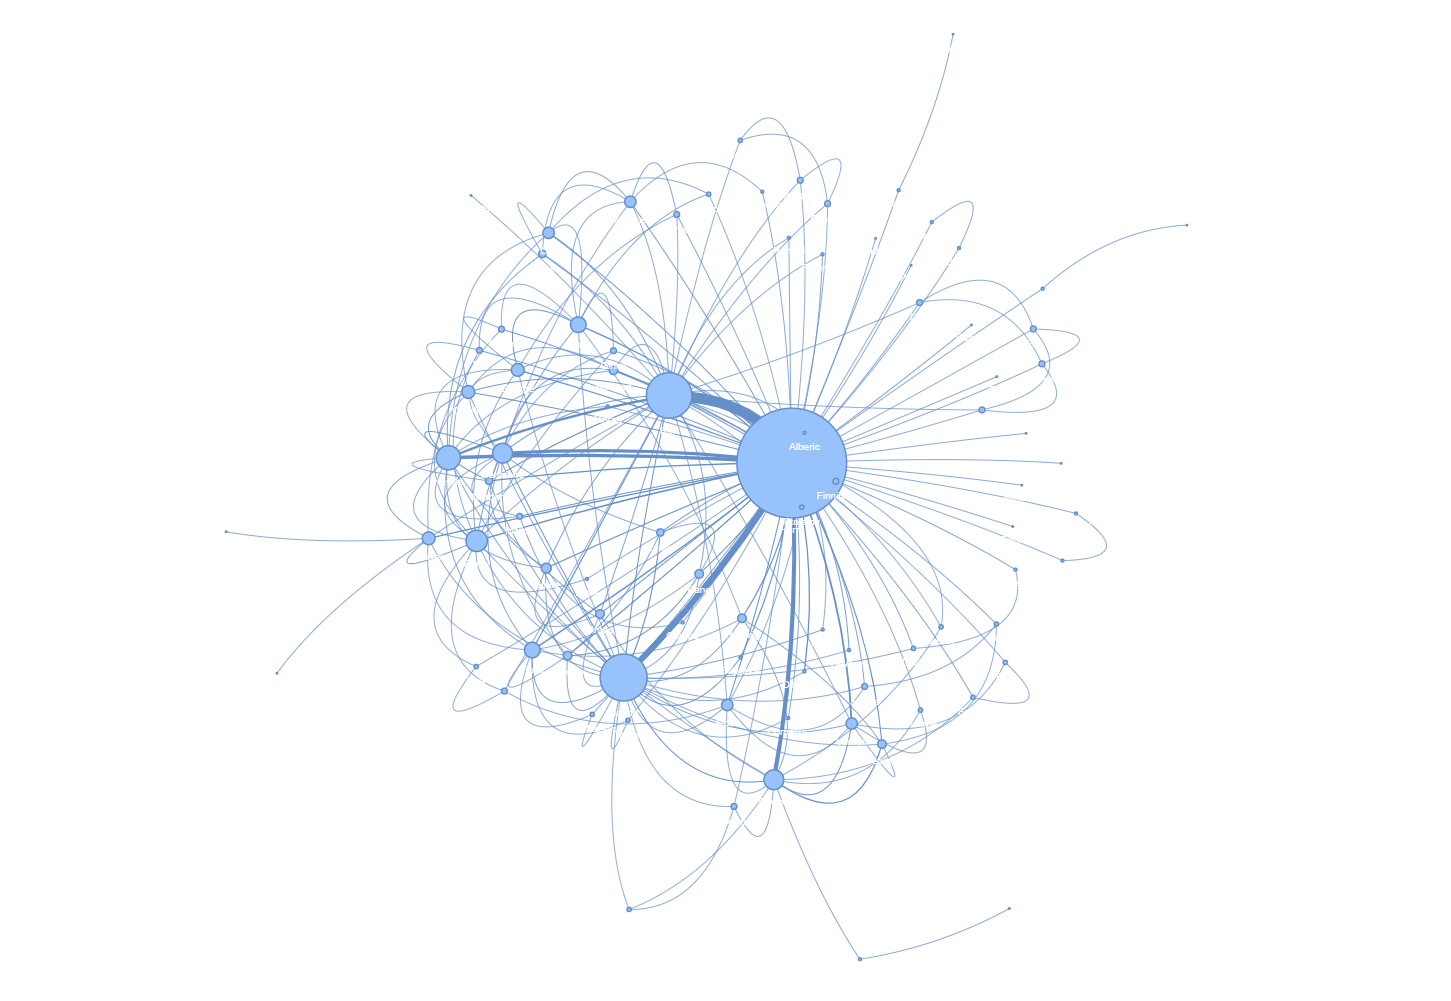

In [75]:
degree_dict = nx.degree_centrality(G)
degree_dict

{'Dudley': 0.16091954022988506,
 'Harry': 0.8850574712643678,
 'Harvey': 0.022988505747126436,
 'Harold': 0.022988505747126436,
 'Petunia': 0.06896551724137931,
 'Albus': 0.09195402298850575,
 'James': 0.04597701149425287,
 'Lily': 0.034482758620689655,
 'Hagrid': 0.3793103448275862,
 'Vernon': 0.09195402298850575,
 'Tufty': 0.034482758620689655,
 'Snowy': 0.034482758620689655,
 'Yvonne': 0.034482758620689655,
 'Piers': 0.011494252873563218,
 'Gordon': 0.022988505747126436,
 'Malcolm': 0.011494252873563218,
 'Dennis': 0.011494252873563218,
 'Rubeus': 0.011494252873563218,
 'Minerva': 0.011494252873563218,
 'Bones': 0.04597701149425287,
 'Cornelius': 0.022988505747126436,
 'Adalbert': 0.022988505747126436,
 'Phyllida': 0.011494252873563218,
 'Tom': 0.011494252873563218,
 'Doris': 0.034482758620689655,
 'Dedalus': 0.022988505747126436,
 'Professor': 0.034482758620689655,
 'Griphook': 0.022988505747126436,
 'Malkin': 0.04597701149425287,
 'Flourish': 0.034482758620689655,
 'Vindictus': 0.

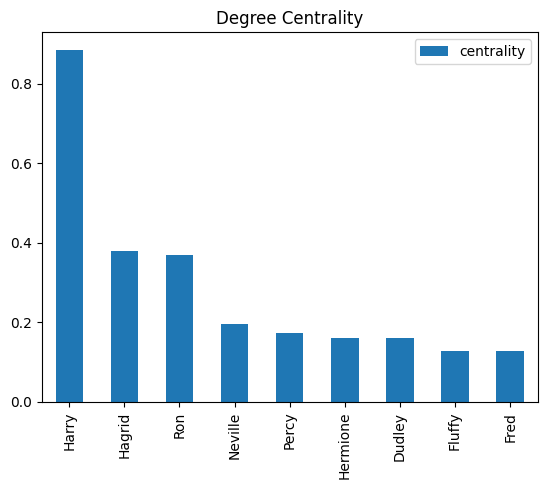

In [76]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns= ['centrality'])

degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind='bar',title='Degree Centrality');

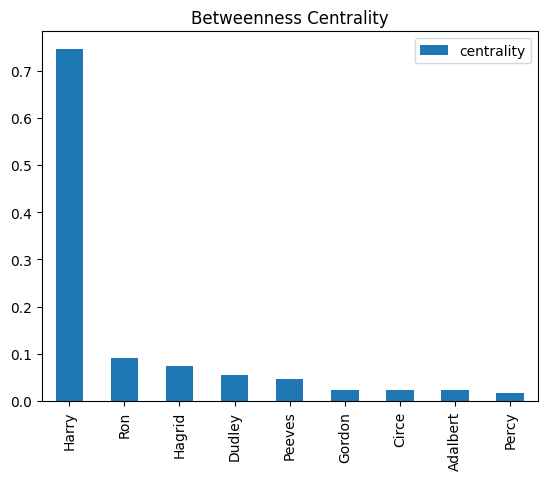

In [77]:
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns= ['centrality'])

betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind='bar', title= 'Betweenness Centrality');

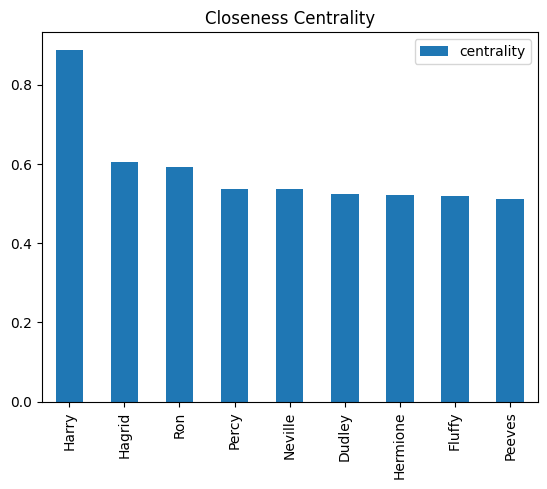

In [78]:
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns= ['centrality'])

closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind='bar', title='Closeness Centrality');

In [81]:
from community import community_louvain

In [82]:
# Send graph to community detection algorithm
communities = community_louvain.best_partition(G)

In [83]:
# Set communites as group attribute
nx.set_node_attributes(G, communities, 'group')

In [86]:
# Visualize network
net = Network(notebook=True, width='1000px', height='1000px', bgcolor='#222222',font_color = 'white',cdn_resources='in_line')
net.repulsion()

net.from_nx(G)
html = net.generate_html()
with open("community.html", mode='w', encoding='utf-8') as fp:
        fp.write(html)

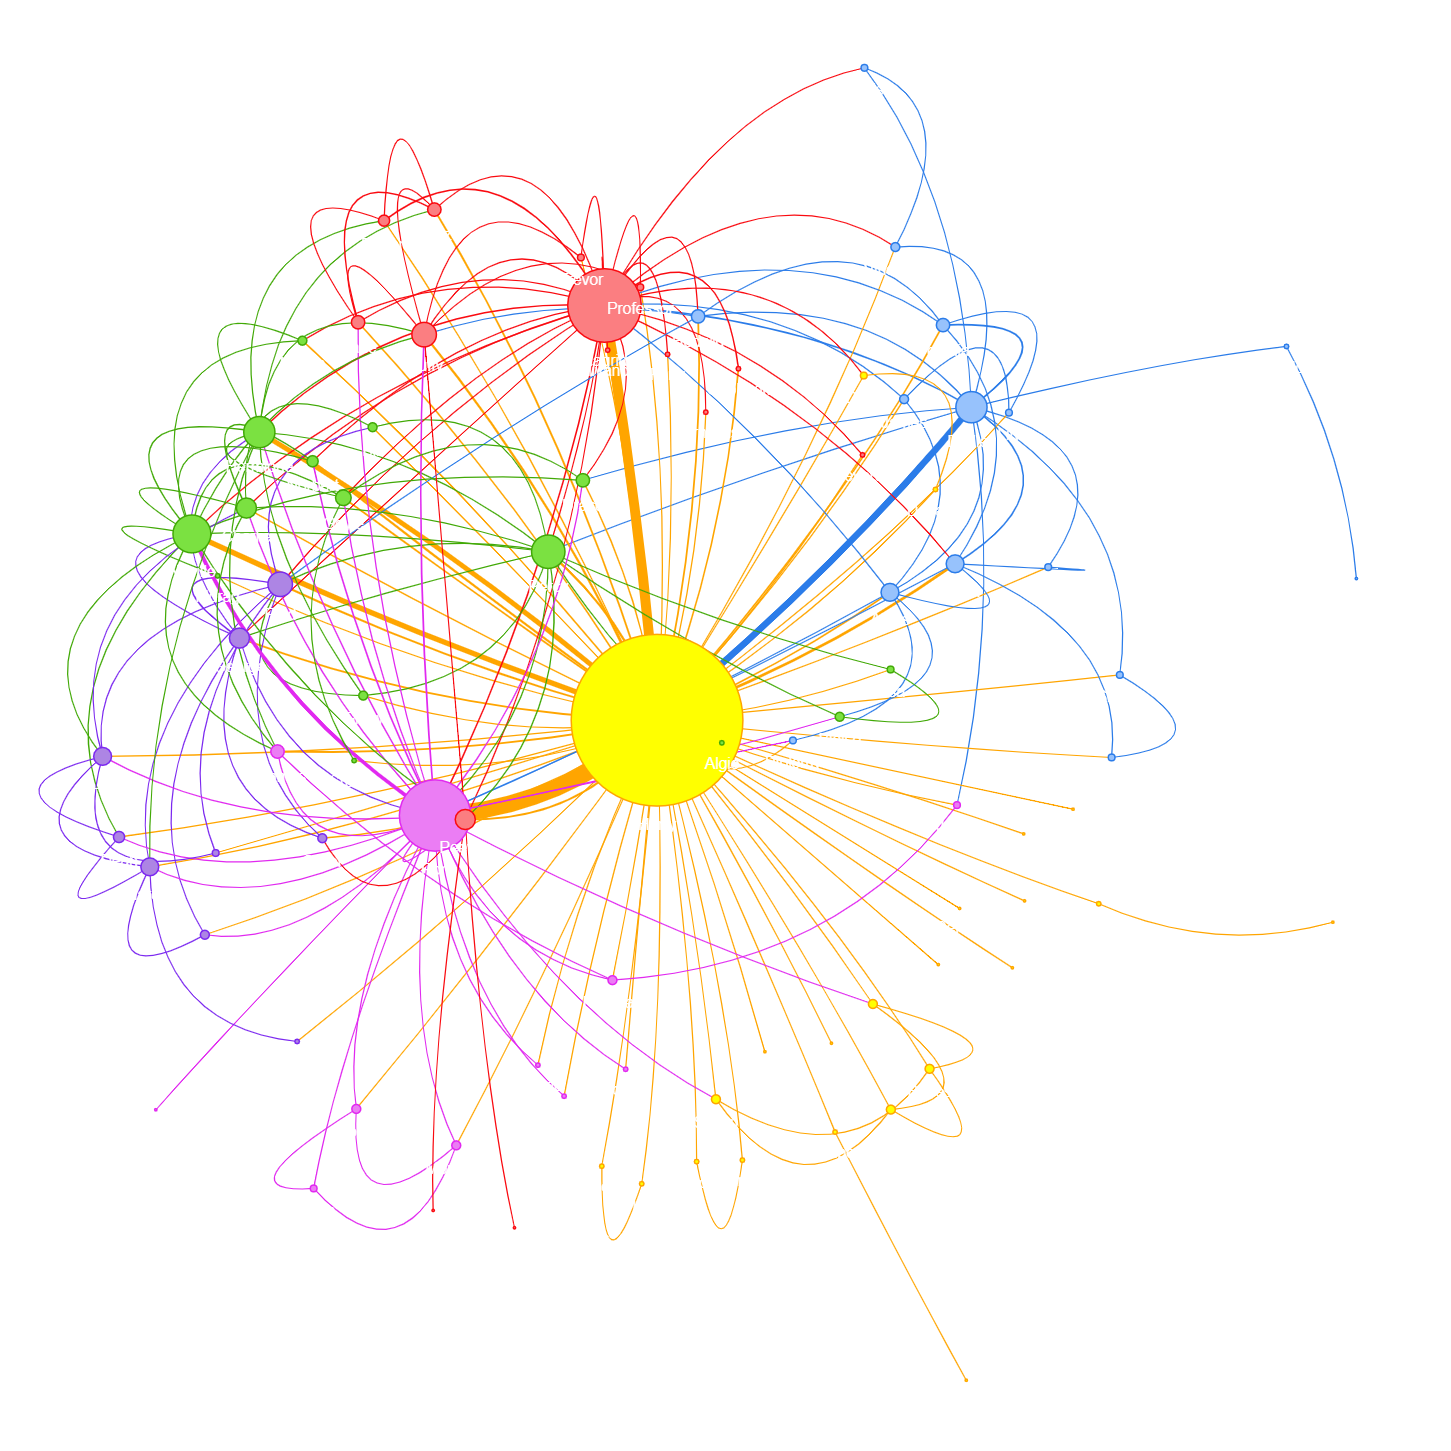

Till now we have looked at the community and character relationships present in the book. Lets now look at further information that we can gather from the various characters.

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

In [98]:
char_df = pd.read_csv("D:\Purvi\Book-character-visualizations\harry_potter\data\Characters.csv", sep=';')

In [99]:
char_df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Skills,Birth,Death
0,1,Harry James Potter,Male,Student,Gryffindor,"11"" Holly phoenix feather",Stag,Human,Half-blood,Black,Bright green,Albus Dumbledore | Dumbledore's Army | Order o...,Parseltongue| Defence Against the Dark Arts | ...,31 July 1980,NaN
1,2,Ronald Bilius Weasley,Male,Student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,Human,Pure-blood,Red,Blue,Dumbledore's Army | Order of the Phoenix | Hog...,Wizard chess | Quidditch goalkeeping,1 March 1980,NaN
2,3,Hermione Jean Granger,Female,Student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,Human,Muggle-born,Brown,Brown,Dumbledore's Army | Order of the Phoenix | Hog...,Almost everything,"19 September, 1979",NaN
3,4,Albus Percival Wulfric Brian Dumbledore,Male,Headmaster,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,Human,Half-blood,Silver| formerly auburn,Blue,Dumbledore's Army | Order of the Phoenix | Hog...,Considered by many to be one of the most power...,Late August 1881,"30 June, 1997"
4,5,Rubeus Hagrid,Male,Keeper of Keys and Grounds | Professor of Care...,Gryffindor,"16"" Oak unknown core",NaN,Half-Human/Half-Giant,Part-Human (Half-giant),Black,Black,Albus Dumbledore | Order of the Phoenix | Hogw...,Resistant to stunning spells| above average st...,6 December 1928,NaN


## Houses in Harry Potter
As we all know, there were 4 major houses present in Hogwarts- Gryffindor, Slytherin, Hufflepuff, Ravenclaw - along with the other schools that came in goblet of fire. I was curious to see what was the percentage of the major characters that belonged to each house. Lets find out!

In [106]:
house_counts = char_df['House'].value_counts()

Text(0.5, 1.0, 'Distribution of Houses in Harry Potter')

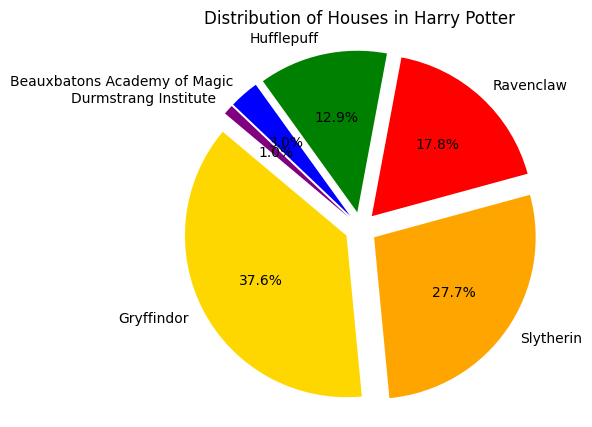

In [111]:
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
plt.figure(figsize=(5, 5))
plt.pie(house_counts, labels=house_counts.index, autopct='%1.1f%%', startangle=140, colors=['gold', 'orange', 'red', 'green', 'blue', 'purple'], explode=explode)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Distribution of Houses in Harry Potter")

Not surprisingly, the majority belongs to Gryffindor and Slytherin.

## Gender Distribution in Harry Potter
The first Harry Potter book was published in 1997, when women were still not given as much rights as men. Sexism was still imminent in the literature industry and in the minds of the society. Does this creep into the books as well?

In [112]:
gender_counts = char_df['Gender'].value_counts()

Text(0.5, 1.0, 'Distribution of Houses in Harry Potter')

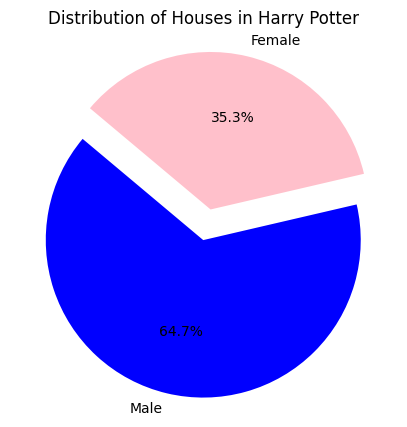

In [114]:
explode = (0.1, 0.1)
plt.figure(figsize=(5, 5))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=['blue', 'pink'], explode=explode)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Distribution of Houses in Harry Potter")

As we can see, even though Harry Potter is written by J.K. Rowling, a woman writer, still the majority of cast is male. This shows a lack of female representation in the series.

## Species Distribution in Harry Potter
There is a reason it is called the Harry Potter "Universe". This is because there are a wide range of species present in the series, not just humans. This led me to visualize the distribution of these species across the series.

In [115]:
species_counts = char_df['Species'].value_counts()

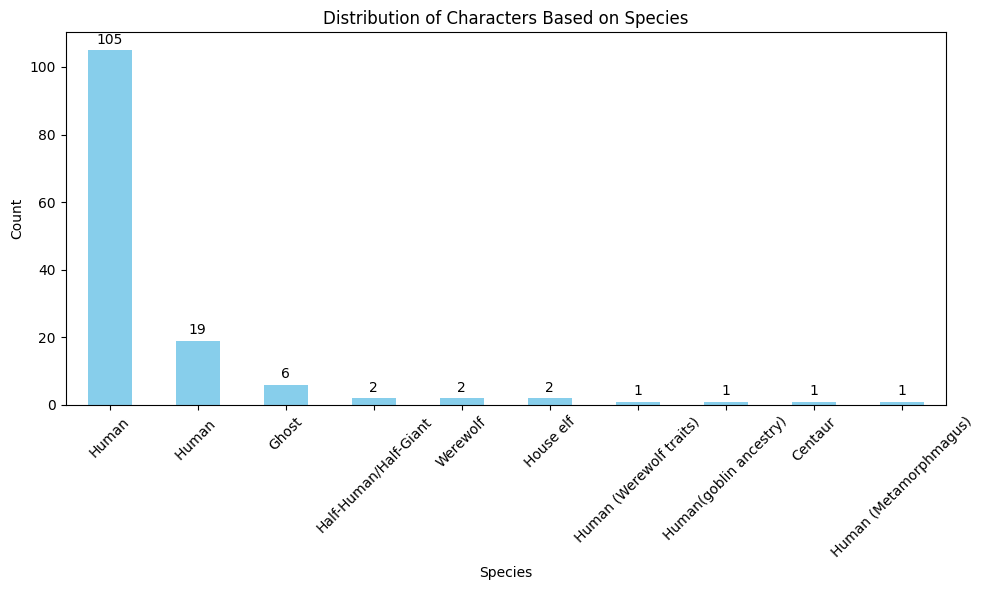

In [124]:
plt.figure(figsize=(10, 6))
ax = species_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Species')
plt.ylabel('Count')
plt.title('Distribution of Characters Based on Species')
plt.xticks(rotation=45)
for i, count in enumerate(species_counts):
    ax.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

### Some additional visualisations

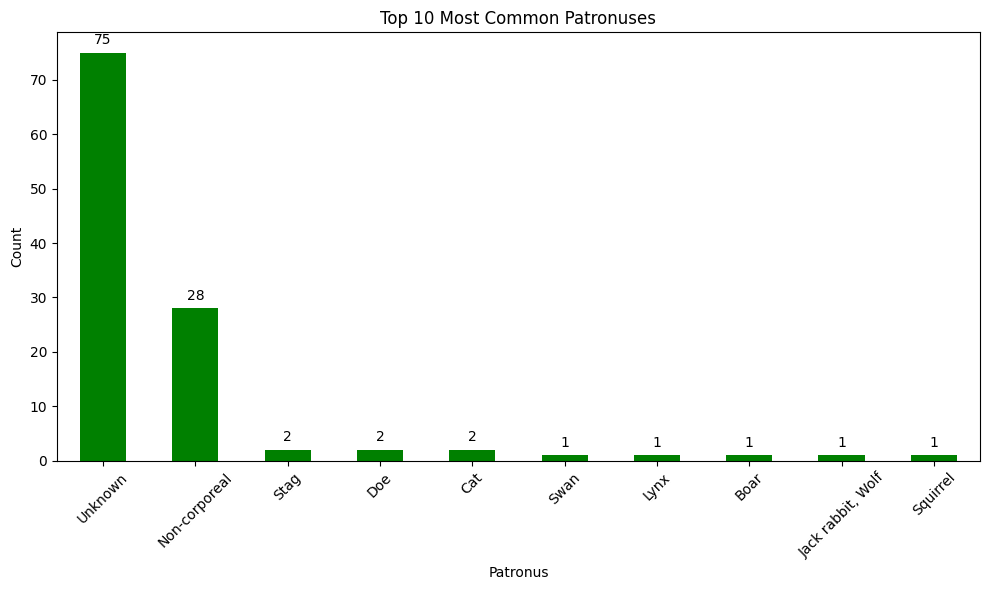

In [136]:
patronus_counts = char_df['Patronus'].value_counts()

# Get the top 10 most common Patronuses
top_10_patronuses = patronus_counts.head(10)

# Create a bar chart for top 10 most common Patronuses
plt.figure(figsize=(10, 6))
ax = top_10_patronuses.plot(kind='bar', color='green')
plt.xlabel('Patronus')
plt.ylabel('Count')
plt.title('Top 10 Most Common Patronuses')
plt.xticks(rotation=45)

# Add count labels above the bars
for i, v in enumerate(top_10_patronuses):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()

# Show the bar chart
plt.show()

C:\Users\Purvi\AppData\Local\Temp\ipykernel_29932\2751953634.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Cluster'] = kmeans.fit_predict(data)


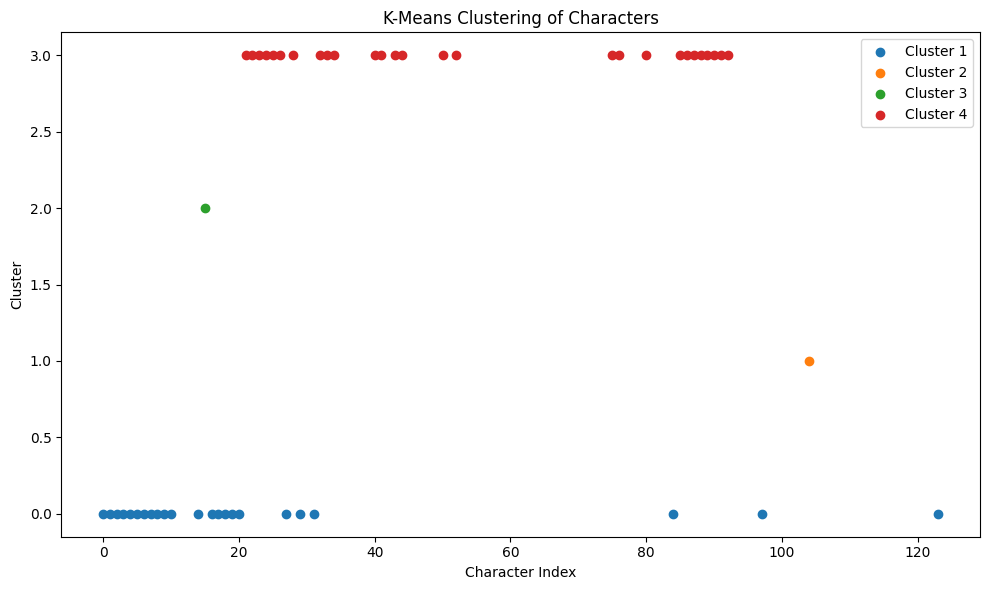

In [154]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Filter out characters with null values in relevant attributes
filtered_df = char_df.dropna(subset=['House', 'Gender', 'Loyalty', 'Job', 'Blood status'])

# Select categorical attributes for clustering
categorical_attributes = ['House', 'Gender', 'Loyalty', 'Job', 'Blood status']

# One-hot encode categorical attributes
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(filtered_df[categorical_attributes]).toarray()

# Standardize the data
scaler = StandardScaler()
data = scaler.fit_transform(encoded_data)

# Perform K-Means clustering
n_clusters = 4  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
filtered_df['Cluster'] = kmeans.fit_predict(data)

# Visualize clusters
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    cluster_data = filtered_df[filtered_df['Cluster'] == cluster]
    plt.scatter(cluster_data.index, cluster_data['Cluster'], label=f'Cluster {cluster + 1}')
plt.xlabel('Character Index')
plt.ylabel('Cluster')
plt.title('K-Means Clustering of Characters')
plt.legend()
plt.tight_layout()

# Show the scatter plot
plt.show()


In [155]:
# Display characters in each cluster
for cluster in range(n_clusters):
    cluster_characters = filtered_df[filtered_df['Cluster'] == cluster]['Name']
    print(f"Cluster {cluster + 1}: {', '.join(cluster_characters)}")

Cluster 1: Harry James Potter, Ronald Bilius Weasley, Hermione Jean Granger, Albus Percival Wulfric Brian Dumbledore, Rubeus Hagrid, Neville Longbottom, Fred Weasley, George Weasley, Ginevra (Ginny) Molly Weasley, Dean Thomas, Seamus Finnigan, Remus John Lupin, Percy Ignatius Weasley, (Bill) William Arthur Weasley, Charles Weasley, Lee Jordan , Oliver Wood, Colin Creevey, Minerva McGonagall, Arthur Weasley, Justin Finch-Fletchley, Frank Longbottom, Dennis Creevey
Cluster 2: Fleur Isabelle Delacour
Cluster 3: Peter Pettigrew
Cluster 4: Angelina Johnson, Katie Bell, Alicia Spinnet, Lavender Brown, Parvati Patil, Romilda Vane, Cormac McLaggen, Quirinus Quirrell, Cho Chang, Luna Lovegood, Padma Patil, Michael Corner, Terry Boot, Anthony Goldstein, Dolores Jane Umbridge, Lucius Malfoy, Alecto Carrow, Amycus Carrow, Nymphadora Tonks, Zacharias Smith, Hannah Abbott, Ernest Macmillan, Susan Bones, Walden Macnair, Augustus Rookwood, Antonin Dolohov, Corban Yaxley
